In [ ]:
! pip install tweepy
! pip install textblob

# Collect Tweets

In [308]:
import tweepy
import twitter_credentials
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from datetime import datetime, timedelta

In [2]:
class TweetCollector():
	"""
	Class for collecting and processing tweets.
	"""

	def clean_tweet(self, tweet):
		return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

	def collect_tweets(self, hashtag, max_tweets):
		tweets = []
		for tweet in tweepy.Cursor(api.search, q=hashtag, lang='en').items(MAX_TWEETS):
			tweets.append(tweet)

		return tweets

	def tweets_to_data_frame(self, tweets):
		df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])

		df['id'] = np.array([tweet.id for tweet in tweets])
		df['len'] = np.array([len(tweet.text) for tweet in tweets])
		df['date'] = np.array([tweet.created_at for tweet in tweets])
		df['source'] = np.array([tweet.source for tweet in tweets])
		df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
		df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

		return df

	def analyze_sentiment(self, tweet):
		analysis = TextBlob(tweet)
		
		'''
		if analysis.sentiment.polarity > 0:
			return 1
		elif analysis.sentiment.polarity == 0:
			return 0
		else:
			return -1
		'''

		return analysis.sentiment.polarity
        

In [109]:
MAX_TWEETS = 10000
since = '2020-01-01'
until = '2020-08-08'

auth = tweepy.OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
api = tweepy.API(auth)

tweet_collector = TweetCollector()

tweets = tweet_collector.collect_tweets(hashtag="#AAPL since:{} until:{}".format(since, until), max_tweets=MAX_TWEETS)
tweets_df = tweet_collector.tweets_to_data_frame(tweets)
tweets_df['tweets'] = pd.DataFrame([tweet_collector.clean_tweet(tweet) for tweet in tweets_df['tweets']])
tweets_df = tweets_df.drop_duplicates(subset=['tweets'])
tweets_df['sentiment'] = np.array([tweet_collector.analyze_sentiment(tweet) for tweet in tweets_df['tweets']])

#[print(tweet, sent) for tweet, sent in zip(tweets_df['tweets'][:30], tweets_df['sentiment'][:30])]

In [110]:
print('daily sentiment score for {} to {}: '.format(since, until),  tweets_df['sentiment'].sum())

daily sentiment score for 2020-01-01 to 2020-08-08:  148.0860377215377


# Remove Spam

Some tweets may be spam, so we try to remove the sources that generally don't contain quality information about sentiment. 

In [5]:
import matplotlib.pyplot as plt

In [111]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143 entries, 0 to 1312
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   tweets     1143 non-null   object        
 1   id         1143 non-null   int64         
 2   len        1143 non-null   int64         
 3   date       1143 non-null   datetime64[ns]
 4   source     1143 non-null   object        
 5   likes      1143 non-null   int64         
 6   retweets   1143 non-null   int64         
 7   sentiment  1143 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 80.4+ KB


In [112]:
tweets_df['source'].unique()

array(['Twitter Web App', 'Hootsuite Inc.', '', 'Google',
       'StockTwits Web', 'Crypto Overvalued/Undervalued', 'IFTTT',
       'Twitter for Android', 'TweetDeck', 'Twitter for iPhone',
       'TradingView', 'Twitter for iPad', 'dlvr.it', 'Gambiste',
       'MagicPot', 'Instagram', 'UTDStockNews', 'TQ Alerts', 'YOUNG APP',
       'Zapier.com', 'WordPress.com', 'HFT DeskTop v2.x', 'Hyderabad Bot',
       'Twitter for Mac', 'Bot Libre!', 'Apple Retweet Bot',
       'TalkMarketsApp', 'Donald Ndoro 2', 'Buffer', 'MeetEdgar',
       'paulcrypto', 'BlueSpy', 'tC_ProgrammingDesignBot', 'LinkedIn',
       'Tweetbot for iΟS', 'Tweetbot for Mac', 'proactive_NA',
       'Twitterrific for Mac', 'Techmeme Editors',
       'aws-twitterbot-workshop', 'Sumanerts'], dtype=object)

### Cumulative Sentiment

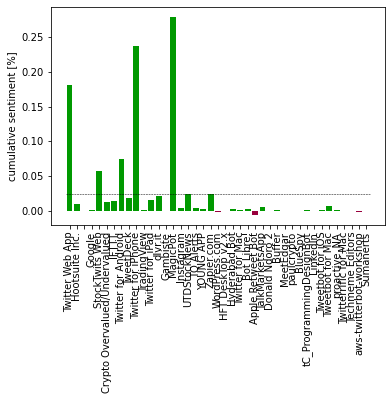

In [113]:
cum_sentiment = []
for source in tweets_df['source'].unique():
    cum_sentiment.append(tweets_df[tweets_df['source'] == source]['sentiment'].sum() / tweets_df['sentiment'].sum())

#tweets_df['cum_sentiment'] = np.cumsum(tweets_df['sentiment'])
#tweets_df['cum_sentiment'].sort_values('c', ascending=False)[['a','b']].plot.bar(stacked=True)

cols = ['#99003d' if x < 0 else '#009900' for x in cum_sentiment]

plt.bar(range(len(cum_sentiment)), cum_sentiment, color=cols)
plt.xticks(range(len(cum_sentiment)), tweets_df['source'].unique(), rotation='vertical')
plt.hlines(np.mean(cum_sentiment), xmin=-0.5, xmax=len(cum_sentiment)-0.5, linestyles='--', linewidth=0.5, label='mean')
plt.ylabel('cumulative sentiment [%]')
plt.show()

We see that some sources have a higher impact on daily sentiment than others.

### Retweets

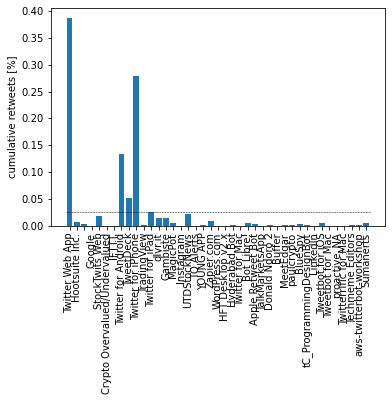

In [114]:
cum_retweets = []
for source in tweets_df['source'].unique():
    cum_retweets.append(tweets_df[tweets_df['source'] == source]['retweets'].sum() / tweets_df['retweets'].sum())

plt.bar(range(len(cum_retweets)), cum_retweets)
plt.xticks(range(len(cum_retweets)), tweets_df['source'].unique(), rotation='vertical')
plt.hlines(np.mean(cum_retweets), xmin=-0.5, xmax=len(cum_retweets)-0.5, linestyles='--', linewidth=0.5, label='mean')
plt.ylabel('cumulative retweets [%]')
plt.show()

We see that some sources are never or rarely retweeted, possibly indicating they have useless content.

### Cum. Sentiment and Retweets

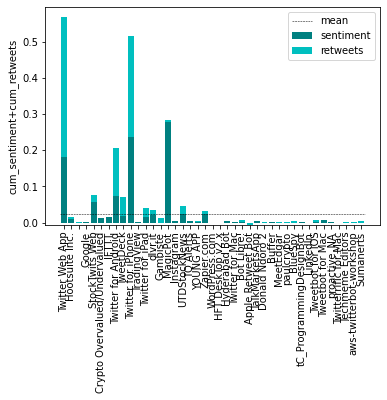

In [115]:
plt.bar(tweets_df['source'].unique(), cum_sentiment, color='teal', label='sentiment')
plt.bar(tweets_df['source'].unique(), cum_retweets, bottom=cum_sentiment, color='c', label='retweets')
plt.hlines(y=np.mean(cum_sentiment+cum_retweets), xmin=-0.5, xmax=len(cum_retweets)-0.5, linestyles='--', linewidth=0.5, label='mean')
plt.ylabel('cum_sentiment+cum_retweets')
plt.xticks(range(len(cum_retweets)), tweets_df['source'].unique(), rotation='vertical')
plt.legend()
plt.show()

The following sources have cum. sentiment and retweets below the mean value, so we exclude them. **We could also choose a certain quantile as threshhold. We should maybe exclude sources under Cum. Sentiment and Retweet threshhold individually, as a source could have a lot of weight on sentiment but no retweets**.

In [116]:
'''
list_sum = np.array([x + y for x, y in zip(cum_sentiment, cum_retweets)])
to_drop = tweets_df['source'].unique()[list_sum < np.mean(cum_sentiment+cum_retweets)]
print(to_drop)
'''

"\nlist_sum = np.array([x + y for x, y in zip(cum_sentiment, cum_retweets)])\nto_drop = tweets_df['source'].unique()[list_sum < np.mean(cum_sentiment+cum_retweets)]\nprint(to_drop)\n"

In [117]:
sent_to_drop = tweets_df['source'].unique()[cum_sentiment < np.mean(cum_sentiment)]
ret_to_drop = tweets_df['source'].unique()[cum_retweets < np.mean(cum_retweets)]
to_drop = list(set(sent_to_drop) | set(ret_to_drop))

In [118]:
tweets_df = tweets_df[~tweets_df['source'].isin(to_drop)]

In [119]:
tweets_df['source'].unique()

array(['Twitter Web App', 'Twitter for Android', 'Twitter for iPhone'],
      dtype=object)

In [120]:
tweets_df.shape

(706, 8)

The textblob module for sentiment analysis is not great. Will implement BERT.

# Compute Sentiment Score for Date Range

In [121]:
gb = tweets_df.groupby(tweets_df.date.dt.date)

In [131]:
gb.get_group('2020-08-07')

,tweets,id,len,date,source,likes,retweets,sentiment
0,AAPL I really know what the 4 1 stock split is...,1291769075039965186,139,2020-08-07 16:12:02,Twitter Web App,0,0,0.100000
2,RT is not going to do anything that would crea...,1291764703115522050,140,2020-08-07 15:54:39,Twitter Web App,0,1,0.000000
4,Apple Inc AAPL shares are down 0 76 in the cur...,1291764134904832000,126,2020-08-07 15:52:24,Twitter Web App,1,1,-0.077778
5,is not going to do anything that would create ...,1291760328720580609,139,2020-08-07 15:37:16,Twitter Web App,3,1,0.000000
10,Investors still needs AAPL s,1291751291098669057,30,2020-08-07 15:01:22,Twitter Web App,0,0,0.000000
11,Want to see what Smart Money is trading Join Q...,1291748424157663234,140,2020-08-07 14:49:58,Twitter for Android,0,0,0.071429
12,My Video has 3 stocks setting up perfectly to ...,1291742788166524928,140,2020-08-07 14:27:34,Twitter Web App,0,0,0.500000
14,RT Careful what you ask for If Trust Wallet ca...,1291731636682395651,140,2020-08-07 13:43:16,Twitter Web App,0,1,-0.100000
15,Careful what you ask for If Trust Wallet can w...,1291728859474333697,139,2020-08-07 13:32:13,Twitter Web App,4,1,-0.100000
16,RH acting up today aapl aapl apple stock,1291727579100123138,69,2020-08-07 13:27:08,Twitter for Android,0,0,0.000000


In [137]:
daily_sentiment = {}
dates = pd.to_datetime(tweets_df.date.dt.strftime('%Y-%m-%d')).unique()
daily_sentiment['dates'] = dates
daily_sentiment['sentiment'] = [gb.get_group(date).sentiment.sum() for date in dates]

In [139]:
daily_sentiment = pd.DataFrame(daily_sentiment)
daily_sentiment

,dates,sentiment
0,2020-08-07,2.396429
1,2020-08-06,3.653077
2,2020-08-05,4.657285
3,2020-08-04,8.328066
4,2020-08-03,7.553068
5,2020-08-02,2.008207
6,2020-08-01,3.167406
7,2020-07-31,18.179862
8,2020-07-30,19.403752
9,2020-07-29,3.633333


In [140]:
'''
start_dates = pd.date_range(start="2020-07-01",end="2020-08-07").strftime('%Y-%m-%d')
end_dates = pd.date_range(start="2020-07-02",end="2020-08-08").strftime('%Y-%m-%d')

print(start_dates)
print(end_dates)
'''

'\nstart_dates = pd.date_range(start="2020-07-01",end="2020-08-07").strftime(\'%Y-%m-%d\')\nend_dates = pd.date_range(start="2020-07-02",end="2020-08-08").strftime(\'%Y-%m-%d\')\n\nprint(start_dates)\nprint(end_dates)\n'

In [141]:
'''
MAX_TWEETS = 10000

auth = tweepy.OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
api = tweepy.API(auth)

tweet_collector = TweetCollector()

sentiment_df = {}

for start_date, end_date in zip(start_dates, end_dates):

    try:
        tweets = tweet_collector.collect_tweets(hashtag="#AAPL since:{} until:{}".format(start_date, end_date), max_tweets=MAX_TWEETS)
        tweets_df = tweet_collector.tweets_to_data_frame(tweets)
        tweets_df['tweets'] = pd.DataFrame([tweet_collector.clean_tweet(tweet) for tweet in tweets_df['tweets']])
        tweets_df = tweets_df.drop_duplicates(subset=['tweets'])
        tweets_df['sentiment'] = np.array([tweet_collector.analyze_sentiment(tweet) for tweet in tweets_df['tweets']])

        sentiment_df[start_date] = tweets_df['sentiment']
    except:
        sentiment_df[start_date] = 0
'''

'\nMAX_TWEETS = 10000\n\nauth = tweepy.OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)\napi = tweepy.API(auth)\n\ntweet_collector = TweetCollector()\n\nsentiment_df = {}\n\nfor start_date, end_date in zip(start_dates, end_dates):\n\n    try:\n        tweets = tweet_collector.collect_tweets(hashtag="#AAPL since:{} until:{}".format(start_date, end_date), max_tweets=MAX_TWEETS)\n        tweets_df = tweet_collector.tweets_to_data_frame(tweets)\n        tweets_df[\'tweets\'] = pd.DataFrame([tweet_collector.clean_tweet(tweet) for tweet in tweets_df[\'tweets\']])\n        tweets_df = tweets_df.drop_duplicates(subset=[\'tweets\'])\n        tweets_df[\'sentiment\'] = np.array([tweet_collector.analyze_sentiment(tweet) for tweet in tweets_df[\'tweets\']])\n\n        sentiment_df[start_date] = tweets_df[\'sentiment\']\n    except:\n        sentiment_df[start_date] = 0\n'

In [142]:
'''
daily_sentiment = [sentiment_df[key].sum() for key in sentiment_df.keys()]
daily_sentiment
'''

'\ndaily_sentiment = [sentiment_df[key].sum() for key in sentiment_df.keys()]\ndaily_sentiment\n'

In [ ]:
! pip install yfinance

In [143]:
import yfinance as yf

In [166]:
dates = pd.to_datetime(tweets_df.date.dt.strftime('%Y-%m-%d').unique())
dates

DatetimeIndex(['2020-08-07', '2020-08-06', '2020-08-05', '2020-08-04',
               '2020-08-03', '2020-08-02', '2020-08-01', '2020-07-31',
               '2020-07-30', '2020-07-29'],
              dtype='datetime64[ns]', freq=None)

In [167]:
aapl = yf.download('AAPL',dates[-1].strftime('%Y-%m-%d'),dates[0].strftime('%Y-%m-%d'))
aapl.shape

[*********************100%***********************]  1 of 1 completed


(7, 6)

# CUMSUM WEEKENDS TO MONDAY

In [190]:
aapl['Close']

Date
2020-07-29    380.160004
2020-07-30    384.760010
2020-07-31    425.040009
2020-08-03    435.750000
2020-08-04    438.660004
2020-08-05    440.250000
2020-08-06    455.609985
Name: Close, dtype: float64

In [197]:
daily_sentiment.dates[::-1]

9   2020-07-29
8   2020-07-30
7   2020-07-31
6   2020-08-01
5   2020-08-02
4   2020-08-03
3   2020-08-04
2   2020-08-05
1   2020-08-06
0   2020-08-07
Name: dates, dtype: datetime64[ns]

In [204]:
non_trading_days = list(set(daily_sentiment.dates[::-1]) - set(aapl.index))
non_trading_days.sort()
non_trading_days

[Timestamp('2020-08-01 00:00:00'),
 Timestamp('2020-08-02 00:00:00'),
 Timestamp('2020-08-07 00:00:00')]

In [225]:
daily_sentiment

,dates,sentiment
0,2020-08-07,2.396429
1,2020-08-06,3.653077
2,2020-08-05,4.657285
3,2020-08-04,8.328066
4,2020-08-03,7.553068
5,2020-08-02,2.008207
6,2020-08-01,3.167406
7,2020-07-31,18.179862
8,2020-07-30,19.403752
9,2020-07-29,3.633333


In [254]:
aapl.index

DatetimeIndex(['2020-07-29', '2020-07-30', '2020-07-31', '2020-08-03',
               '2020-08-04', '2020-08-05', '2020-08-06'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [251]:
(daily_sentiment.dates[0] - daily_sentiment.dates[1] == timedelta(days=1))

True

In [252]:
[1 if (daily_sentiment.dates[i] - daily_sentiment.dates[i+1] == timedelta(days=1)) else 0 for i in range(daily_sentiment.shape[0]-1)]

[1, 1, 1, 1, 1, 1, 1, 1, 1]

In [239]:
is_consec = [True if (non_trading_days[i+1] - non_trading_days[i] == timedelta(days=1)) else False for i in range(len(non_trading_days)-1)]
is_consec


[True, False]

In [243]:
daily_sentiment.dates

0   2020-08-07
1   2020-08-06
2   2020-08-05
3   2020-08-04
4   2020-08-03
5   2020-08-02
6   2020-08-01
7   2020-07-31
8   2020-07-30
9   2020-07-29
Name: dates, dtype: datetime64[ns]

# PLOT

In [261]:
drop_idx = list(set(daily_sentiment.dates[::-1]) - set(aapl.index))
drop_idx

[Timestamp('2020-08-01 00:00:00'),
 Timestamp('2020-08-07 00:00:00'),
 Timestamp('2020-08-02 00:00:00')]

In [262]:
daily_sentiment = daily_sentiment[~daily_sentiment.dates.isin(drop_idx)]
daily_sentiment

,dates,sentiment
1,2020-08-06,3.653077
2,2020-08-05,4.657285
3,2020-08-04,8.328066
4,2020-08-03,7.553068
7,2020-07-31,18.179862
8,2020-07-30,19.403752
9,2020-07-29,3.633333


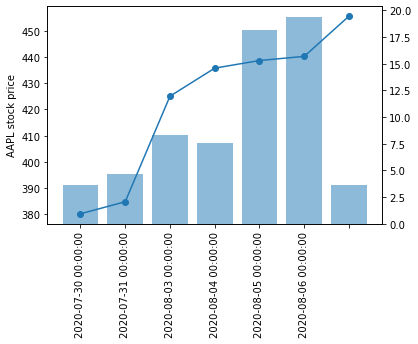

In [279]:
fig, ax1 = plt.subplots()

ax1.plot(range(aapl.shape[0]), aapl['Close'], '-o')
plt.ylabel('AAPL stock price')
ax2 = ax1.twinx()
ax2.bar(range(aapl.shape[0]), daily_sentiment.sentiment, alpha=0.5)


ax1.set_xticklabels(aapl.index, rotation='vertical')
plt.show()

# MORE DATA

In [ ]:
MAX_TWEETS = 10000
since = '2020-01-01'
until = '2020-08-08'

auth = tweepy.OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
api = tweepy.API(auth)

tweet_collector = TweetCollector()

In [302]:
start_dates[0]-timedelta(1)

Timestamp('2020-06-30 00:00:00', freq='D')

In [325]:
start_dates = pd.date_range(start="2020-07-20",end="2020-08-07").strftime('%Y-%m-%d')
end_dates = pd.date_range(start="2020-07-21",end="2020-08-08").strftime('%Y-%m-%d')

print(start_dates)
print(end_dates)

Index(['2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
       '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29',
       '2020-07-30', '2020-07-31', '2020-08-01', '2020-08-02', '2020-08-03',
       '2020-08-04', '2020-08-05', '2020-08-06', '2020-08-07'],
      dtype='object')
Index(['2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
       '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30',
       '2020-07-31', '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04',
       '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08'],
      dtype='object')


In [317]:
MAX_TWEETS = 10000

auth = tweepy.OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
api = tweepy.API(auth)

tweet_collector = TweetCollector()

In [326]:
sentiment_df = {}

for start_date, end_date in zip(start_dates, end_dates):

    try:
        tweets = tweet_collector.collect_tweets(hashtag="#AAPL since:{} until:{}".format(start_date, end_date), max_tweets=MAX_TWEETS)
        tweets_df = tweet_collector.tweets_to_data_frame(tweets)
        tweets_df['tweets'] = pd.DataFrame([tweet_collector.clean_tweet(tweet) for tweet in tweets_df['tweets']])
        tweets_df = tweets_df.drop_duplicates(subset=['tweets'])
        tweets_df['sentiment'] = np.array([tweet_collector.analyze_sentiment(tweet) for tweet in tweets_df['tweets']])

        sentiment_df[start_date] = tweets_df['sentiment']
    except:
        sentiment_df[start_date] = 0
        
    break

In [329]:
sentiment_df

{'2020-07-20': 0}

In [327]:
sentiment_df['2020-08-01'].sum()

KeyError: '2020-08-01'